In [3]:
import numpy as np
import matplotlib.pyplot as plt

# torch/pyro imports
import torch
from torch import nn
import pyro
from pyro.infer import SVI, TraceEnum_ELBO, Predictive, NUTS, MCMC, config_enumerate
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam, ClippedAdam
import pyro.distributions as dist

from mdn.mixture_density_nets import MDN, PyroMDN
from mdn import utils

In [5]:
plt.style.use("ggplot")

### Data

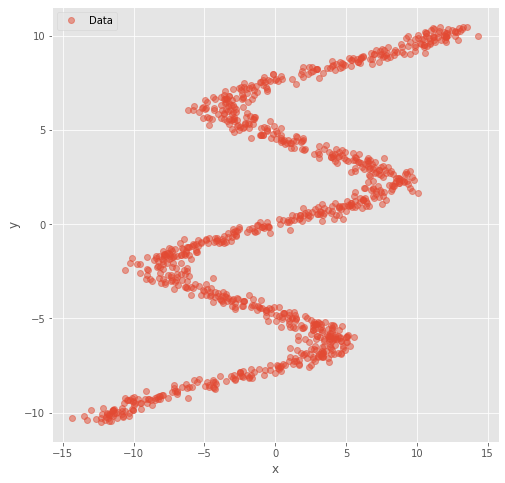

In [6]:
# Generate data
num_samples = 1000
x_data, y_data = utils.generate_regression_data(num_samples)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'o',alpha=0.5, label="Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [11]:
# build tensors
X_tensor = torch.from_numpy(x_data).float()
y_tensor = torch.from_numpy(y_data).float()
X_tensor.shape, y_tensor.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

This data is obviously particularly interesting because our network will need to output multiple possible locations for a given $x$. This is something that would not be possible if we were assuming a uni-modal target distribution (e.g. Gaussian).

## Mixture Density Nets

In [7]:
mdn = PyroMDN(input_dim=1, hidden_dim=128, output_dim=1, K=10, use_cuda=False, verbose=False)

In [8]:
optimizer = pyro.optim.ClippedAdam({"lr": 0.001, "clip_norm": 5.})

In [9]:
svi = SVI(mdn.model, mdn.guide, optimizer, TraceEnum_ELBO(num_particles=1, max_plate_nesting=1))

In [12]:
pyro.clear_param_store()
num_epochs = 10000
losses = []

for epoch in range(num_epochs):
    try:
        loss = svi.step(X_tensor, y_tensor) / len(X_tensor)
        losses.append(loss)
        if epoch%200 == 199 or epoch == 0:
            print("Epoch: {0}, ELBO: {1:.3f}".format(epoch+1, loss))
    except KeyboardInterrupt:
        plt.plot(losses);
        break

Epoch: 1, ELBO: 15.212
Epoch: 200, ELBO: 2.483
Epoch: 400, ELBO: 2.251
Epoch: 600, ELBO: 2.002
Epoch: 800, ELBO: 1.962
Epoch: 1000, ELBO: 1.916
Epoch: 1200, ELBO: 1.881
Epoch: 1400, ELBO: 1.873
Epoch: 1600, ELBO: 1.867
Epoch: 1800, ELBO: 1.838
Epoch: 2000, ELBO: 1.843
Epoch: 2200, ELBO: 1.847
Epoch: 2400, ELBO: 1.840
Epoch: 2600, ELBO: 1.772
Epoch: 2800, ELBO: 1.748
Epoch: 3000, ELBO: 1.774
Epoch: 3200, ELBO: 1.802
Epoch: 3400, ELBO: 1.754
Epoch: 3600, ELBO: 1.751
Epoch: 3800, ELBO: 1.803
Epoch: 4000, ELBO: 1.744
Epoch: 4200, ELBO: 1.732
Epoch: 4400, ELBO: 1.736
Epoch: 4600, ELBO: 1.732
Epoch: 4800, ELBO: 1.717
Epoch: 5000, ELBO: 1.702
Epoch: 5200, ELBO: 1.725
Epoch: 5400, ELBO: 1.732
Epoch: 5600, ELBO: 1.691
Epoch: 5800, ELBO: 1.726
Epoch: 6000, ELBO: 1.696
Epoch: 6200, ELBO: 1.702
Epoch: 6400, ELBO: 1.640
Epoch: 6600, ELBO: 1.666
Epoch: 6800, ELBO: 1.645
Epoch: 7000, ELBO: 1.647
Epoch: 7200, ELBO: 1.663
Epoch: 7400, ELBO: 1.619
Epoch: 7600, ELBO: 1.648
Epoch: 7800, ELBO: 1.634
Epoch:

In [13]:
# run forward model -> obtain samples
pi, loc, Sigma_tril, samples = mdn.model(X_tensor, y=None)

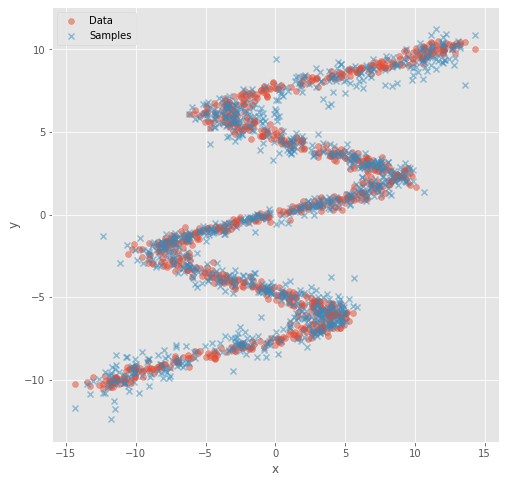

In [14]:
# Plot Data vs Samples from MDN
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data,alpha=0.5, label="Data")
plt.scatter(x_data, samples.detach().numpy(), alpha=0.5, marker="x", label="Samples")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The MDN successfully recovers the true conditional distribution in the data.